<a href="https://colab.research.google.com/github/canxiu-zhang/ML_YUniv/blob/main/group_projects/milestone_2/Milestone_2_Group_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone 3

## 1. EDA

In [2]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [10]:
!pip install contractions
!pip install unicodedata
!pip install scikit-multilearn

ERROR: Could not find a version that satisfies the requirement unicodedata (from versions: none)
ERROR: No matching distribution found for unicodedata


In [3]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import contractions
import unicodedata
import pprint
%pprint

2023-04-19 15:31:26.234774: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Pretty printing has been turned OFF


In [5]:
df = pd.read_csv('../tmdb_movies_data.csv')

### Parse top 5 genres in a column into a binary vector

In [6]:
# Identify the column that contains the multiple genre labels
genre_column = 'genres'

# Create a list of all possible genre labels in your dataset
all_genres = ['Action', 'Comedy', 'Drama', 'Thriller', 'Romance']

# Use get_dummies() to convert the genre column into binary columns
genre_dummies = df[genre_column].str.get_dummies(sep='|').reindex(columns=all_genres, fill_value=1)

# Merge the new DataFrame with the original DataFrame
merged_df = pd.concat([df, genre_dummies], axis=1)

# Drop columns from the DataFrame
merged_df.drop(['imdb_id', 'popularity', 'budget', 'revenue', 'original_title', 'cast', 'homepage', 'director', 'tagline', 'keywords', 'runtime', 'production_companies', 'release_date', 'vote_count', 'vote_average', 'release_year', 'budget_adj', 'revenue_adj'], axis=1, inplace=True)

# Print the new DataFrame
print(merged_df.head())

       id                                           overview  \
0  135397  Twenty-two years after the events of Jurassic ...   
1   76341  An apocalyptic story set in the furthest reach...   
2  262500  Beatrice Prior must confront her inner demons ...   
3  140607  Thirty years after defeating the Galactic Empi...   
4  168259  Deckard Shaw seeks revenge against Dominic Tor...   

                                      genres  Action  Comedy  Drama  Thriller  \
0  Action|Adventure|Science Fiction|Thriller       1       0      0         1   
1  Action|Adventure|Science Fiction|Thriller       1       0      0         1   
2         Adventure|Science Fiction|Thriller       0       0      0         1   
3   Action|Adventure|Science Fiction|Fantasy       1       0      0         0   
4                      Action|Crime|Thriller       1       0      0         1   

   Romance  
0        0  
1        0  
2        0  
3        0  
4        0  


In [7]:
missing_values_check = merged_df.isnull().sum()
print(missing_values_check)

id           0
overview     4
genres      23
Action       0
Comedy       0
Drama        0
Thriller     0
Romance      0
dtype: int64


In [8]:
categories = list(merged_df.columns.values)
categories = categories[3:]
print(categories)

['Action', 'Comedy', 'Drama', 'Thriller', 'Romance']


In [9]:
# Calculating number of comments in each category

counts = []
for category in categories:
    counts.append((category, merged_df[category].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number of overviews'])
df_stats

,category,number of overviews
0,Action,2385
1,Comedy,3793
2,Drama,4761
3,Thriller,2908
4,Romance,1712


## 2. Data Pre-Processing

In [10]:
data = merged_df
data.shape

(10866, 8)

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

### Cleaning Data

In [12]:
def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext


def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned


def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

def removeSpecial(sentence):
    # Remove special characters using regular expression
    clean_text = re.sub(r'[^\w\s]', '', sentence)
    return clean_text

def removeAccent(sentence):
    # Remove accent characters using the unicodedata module
    no_accent_text = ''.join(char for char in unicodedata.normalize('NFD', sentence) if unicodedata.category(char) != 'Mn')
    return no_accent_text

def removeContraction(sentence):
    # Expand contractions using contractions library
    expanded_text = contractions.fix(sentence)
    return expanded_text

In [13]:
data['overview'] = data['overview'].str.lower()
data['overview'] = data['overview'].apply(cleanHtml)
data['overview'] = data['overview'].apply(cleanPunc)
data['overview'] = data['overview'].apply(keepAlpha)
data['overview'] = data['overview'].apply(removeSpecial)
data['overview'] = data['overview'].apply(removeAccent)
data['overview'] = data['overview'].apply(removeContraction)
data.head()

,id,overview,genres,Action,Comedy,Drama,Thriller,Romance
0,135397,twenty two years after the events of jurassic ...,Action|Adventure|Science Fiction|Thriller,1,0,0,1,0
1,76341,an apocalyptic story set in the furthest reach...,Action|Adventure|Science Fiction|Thriller,1,0,0,1,0
2,262500,beatrice prior must confront her inner demons ...,Adventure|Science Fiction|Thriller,0,0,0,1,0
3,140607,thirty years after defeating the galactic empi...,Action|Adventure|Science Fiction|Fantasy,1,0,0,0,0
4,168259,deckard shaw seeks revenge against dominic tor...,Action|Crime|Thriller,1,0,0,1,0


### Removing Stop Words

In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/canxiuzhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

data['overview'] = data['overview'].apply(removeStopWords)
data.head()

,id,overview,genres,Action,Comedy,Drama,Thriller,Romance
0,135397,twenty years events jurassic park isla nub...,Action|Adventure|Science Fiction|Thriller,1,0,0,1,0
1,76341,apocalyptic story set furthest reaches pl...,Action|Adventure|Science Fiction|Thriller,1,0,0,1,0
2,262500,beatrice prior must confront inner demons co...,Adventure|Science Fiction|Thriller,0,0,0,1,0
3,140607,thirty years defeating galactic empire han s...,Action|Adventure|Science Fiction|Fantasy,1,0,0,0,0
4,168259,deckard shaw seeks revenge dominic toretto ...,Action|Crime|Thriller,1,0,0,1,0


### Stemming

In [16]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

# data['overview'] = data['overview'].apply(stemming)
data.head()

,id,overview,genres,Action,Comedy,Drama,Thriller,Romance
0,135397,twenty years events jurassic park isla nub...,Action|Adventure|Science Fiction|Thriller,1,0,0,1,0
1,76341,apocalyptic story set furthest reaches pl...,Action|Adventure|Science Fiction|Thriller,1,0,0,1,0
2,262500,beatrice prior must confront inner demons co...,Adventure|Science Fiction|Thriller,0,0,0,1,0
3,140607,thirty years defeating galactic empire han s...,Action|Adventure|Science Fiction|Fantasy,1,0,0,0,0
4,168259,deckard shaw seeks revenge dominic toretto ...,Action|Crime|Thriller,1,0,0,1,0


### Lemmatization

In [18]:
nlp = spacy.load('en_core_web_sm')
def lemmatization(sentence):
  doc = nlp(sentence)
  lemmas = [token.lemma_ for token in doc]
  lemmas = [l.strip() for l in lemmas]
  return " ".join(lemmas)

data['overview'] = data['overview'].apply(lemmatization)
data.head()

,id,overview,genres,Action,Comedy,Drama,Thriller,Romance
0,135397,twenty year event jurassic park isla nublar...,Action|Adventure|Science Fiction|Thriller,1,0,0,1,0
1,76341,apocalyptic story set furth reach planet s...,Action|Adventure|Science Fiction|Thriller,1,0,0,1,0
2,262500,beatrice prior must confront inner demon con...,Adventure|Science Fiction|Thriller,0,0,0,1,0
3,140607,thirty year defeat galactic empire han solo ...,Action|Adventure|Science Fiction|Fantasy,1,0,0,0,0
4,168259,deckard shaw seek revenge dominic toretto fa...,Action|Crime|Thriller,1,0,0,1,0


### Train-Test Split

In [19]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, random_state=42, test_size=0.30, shuffle=True)

print(train.shape)
print(test.shape)

(7606, 8)
(3260, 8)


In [50]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [51]:
train.to_csv('../train.csv', index=False)
test.to_csv('../test.csv', index=False)

In [52]:
train.shape

(7606, 8)

In [65]:
train = pd.read_csv('../train.csv', keep_default_na=False, na_values=[''])
test = pd.read_csv('../test.csv', keep_default_na=False, na_values=[''])

### Resample Training dataset

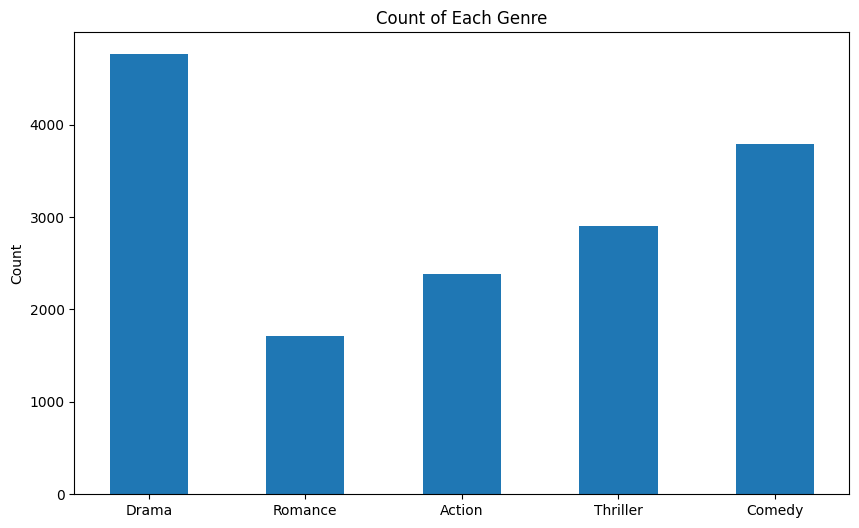

In [66]:
#Plotting the y genre columns:

genre_columns = ['Drama', 'Romance', 'Action', 'Thriller', 'Comedy']
plot_df = data[genre_columns]

# Calculate the sum of each column
column_sums = plot_df.sum(axis=0)

# Set the width of the bars
bar_width = 0.5

# Set the x-axis positions for the bars
x = np.arange(len(column_sums))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bars for each column
ax.bar(x, column_sums, width=bar_width)

# Set the x-axis tick positions and labels
ax.set_xticks(x)
ax.set_xticklabels(column_sums.index)

# Add labels and title
ax.set_ylabel('Count')
ax.set_title('Count of Each Genre')

# Show the plot
plt.show()


## 3. Feature Extraction

### GloVe model

In [33]:
# feature engineering with GloVe model
train_nlp = [nlp(item) for item in train_text]
train_glove_features = np.array([item.vector for item in train_nlp])

test_nlp = [nlp(item) for item in test_text]
test_glove_features = np.array([item.vector for item in test_nlp])

In [34]:
# print('Word2Vec model:> Train features shape:', avg_wv_train_features.shape, ' Test features shape:', avg_wv_test_features.shape)
print('GloVe model:> Train features shape:', train_glove_features.shape, ' Test features shape:', test_glove_features.shape)

GloVe model:> Train features shape: (7606, 96)  Test features shape: (3260, 96)


### word2vec model

In [67]:
import spacy
from nltk.tokenize.toktok import ToktokTokenizer
import gensim
import keras
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense
from sklearn.preprocessing import LabelEncoder
import multiprocessing
from gensim.models import Word2Vec

In [68]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [69]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                    #  size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [70]:
from gensim.models.phrases import Phrases, Phraser
from nltk import bigrams

words = [row.split() for row in train['overview']]
phrases = Phrases(words, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[words]

In [71]:
w2v_model.build_vocab(sentences, progress_per=10000)

In [72]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(2072573, 6735480)

In [73]:
w2v_model.init_sims(replace=True)

In [74]:
w2v_model.wv.most_similar(positive=["life"])

[('love', 0.96544349193573), ('true', 0.9612456560134888), ('change', 0.960820198059082), ('never', 0.9604430198669434), ('friendship', 0.9590816497802734), ('live', 0.959016740322113), ('grow', 0.9555162787437439), ('wonder', 0.9525820016860962), ('like', 0.9523027539253235), ('lesson', 0.9503108263015747)]

In [75]:
w2v_model.wv.most_similar(positive=["find"])

[('soon', 0.9825645685195923), ('discover', 0.9803719520568848), ('someone', 0.9728818535804749), ('anyone', 0.9663382768630981), ('clear', 0.9659850597381592), ('wood', 0.964531660079956), ('stay', 0.964496374130249), ('outside', 0.9627382755279541), ('another', 0.9627212882041931), ('leave', 0.9624848961830139)]

In [76]:
w2v_model.wv.most_similar(positive=["she"])

[('intention', 0.9927593469619751), ('fail', 0.9918494820594788), ('eventually', 0.9915130138397217), ('wait', 0.991166889667511), ('avoid', 0.9907651543617249), ('accept', 0.9900660514831543), ('he', 0.9898894429206848), ('situation', 0.9898183941841125), ('table', 0.9893972873687744), ('unable', 0.9893770217895508)]

In [77]:
tokenizer = ToktokTokenizer()
nlp = spacy.load('en_core_web_sm')

In [78]:
# tokenize train reviews & encode train labels
tokenized_train = [tokenizer.tokenize(text)
                   for text in train_text]
y_train = train.drop(labels = ['id','overview', 'genres'], axis=1)
# tokenize test reviews & encode test labels
tokenized_test = [tokenizer.tokenize(text)
                   for text in test_text]
y_test = test.drop(labels = ['id','overview', 'genres'], axis=1)

In [79]:
# build word2vec model
w2v_num_features = 500
w2v_model = gensim.models.Word2Vec(tokenized_train, vector_size=w2v_num_features, window=150,
                                   min_count=10, sample=1e-3)    

In [80]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [81]:
# generate averaged word vector features from word2vec model
avg_wv_train_features = averaged_word2vec_vectorizer(corpus=tokenized_train, model=w2v_model, num_features=500)
avg_wv_test_features = averaged_word2vec_vectorizer(corpus=tokenized_test, model=w2v_model, num_features=500)

In [83]:
np.savetxt('../avg_wv_train_features.csv', avg_wv_train_features, delimiter=',')
np.savetxt('../avg_wv_test_features.csv', avg_wv_test_features, delimiter=',')

In [84]:
avg_wv_train_features = np.loadtxt('../avg_wv_train_features.csv', delimiter=',')
avg_wv_test_features = np.loadtxt('../avg_wv_test_features.csv', delimiter=',')

In [128]:
train['overview'][5734]

' romantic fantasy movie  people  last survivor  ancient line  goddess worshiper  sell art  shop  teenage daughter rhea fall  love  poetically inclined boy  begin  develop magical power  throw everything  chaos'

In [ ]:
avg_wv_train_features[4]

### t-SNE visualizations

In [46]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [134]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['green']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    # for wrd_score in close_words[:5]:
    #     wrd_vector = model.wv.__getitem__([wrd_score[0]])
    #     word_labels.append(wrd_score[0])
    #     color_list.append('blue')
    #     arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=4).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=3).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-30, Y[:, 0].max()+30)
    plt.ylim(Y[:, 1].min()-30, Y[:, 1].max()+30)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

#### 10 Most similar words vs. 8 Random words

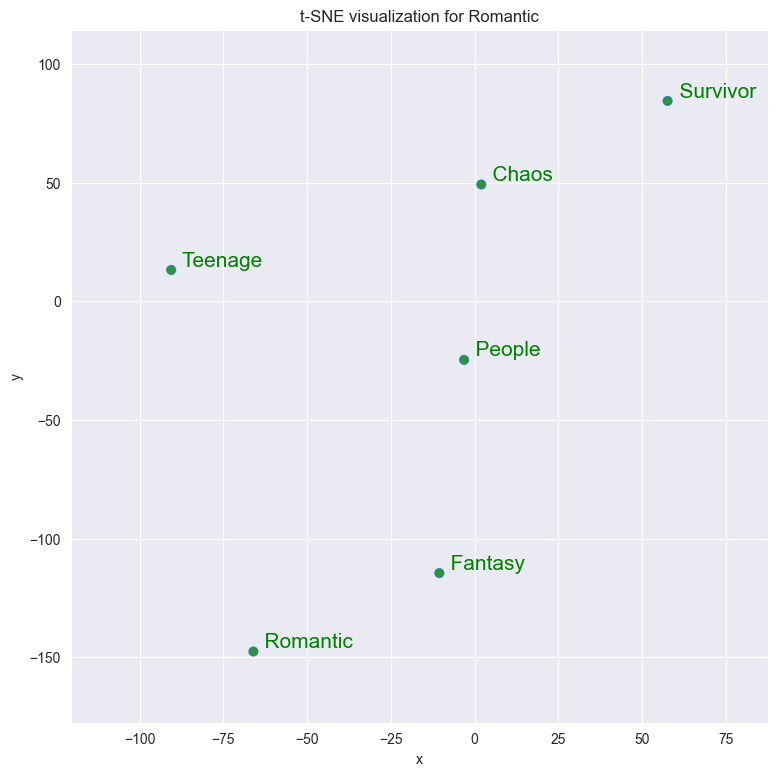

In [136]:
tsnescatterplot(w2v_model, 'romantic', ['fantasy', 'people', 'survivor', 'chaos', 'teenage'])

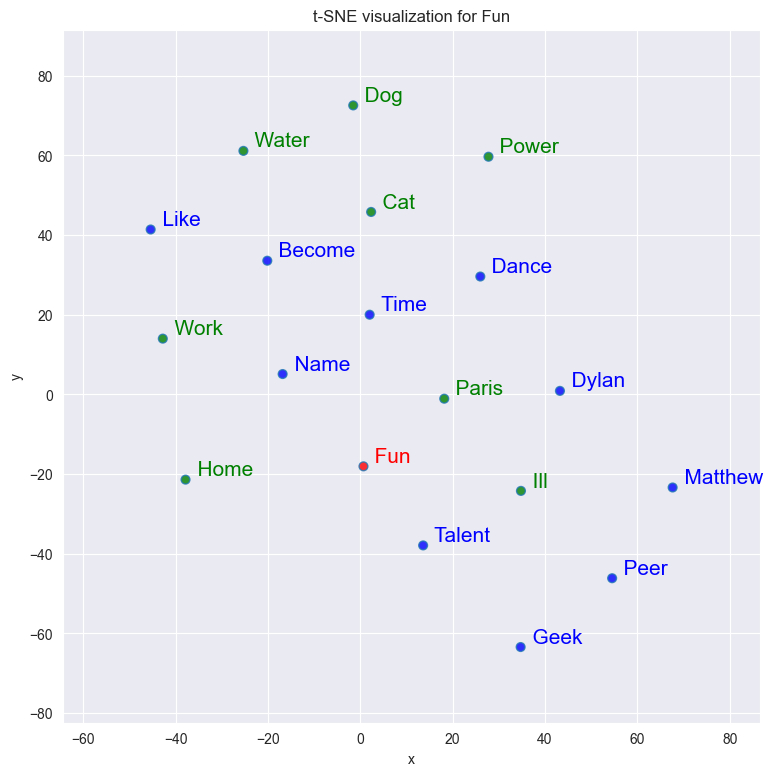

In [65]:
tsnescatterplot(w2v_model, 'fun', ['dog', 'paris', 'home', 'power', 'water', 'cat', 'ill', 'work'])

#### Plot w2v model

In [66]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

words = ['dog', 'paris', 'home', 'power', 'water', 'cat', 'ill', 'work']
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    i = -1
    for word in model.wv.key_to_index:
        i+=1
        if i%30==0:
          tokens.append(model.wv[word])
          labels.append(word)
    
    tsne_model = TSNE(n_components=2, n_iter=2500, random_state=23)
    tokens_array = np.array(tokens)  # convert list to numpy array
    new_values = tsne_model.fit_transform(tokens_array)

    x = new_values[:,0]
    y = new_values[:,1]
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [67]:
tsne_plot(w2v_model)

InvalidParameterError: The 'n_iter' parameter of TSNE must be an int in the range [250, inf). Got 3 instead.

### show word vector

In [60]:
w2v_model.wv.vectors.shape

(3627, 500)

In [ ]:
w2v_model.wv.vectors

In [ ]:
w2v_model.wv.key_to_index

### TF-IDF

Creating Trigrams Using bigrams as inputs in order to provide more contextual meaning vs creating trigrams from scratch. This means that we can consider the relationship between words already captured in the bigrams to provide better overall context. 

In [90]:
from gensim.models.phrases import Phrases, Phraser
from nltk import bigrams, trigrams

words = [row.split() for row in train['overview']]

# First create bigrams
bigram_phrases = Phrases(words, min_count=30, progress_per=10000)
bigram = Phraser(bigram_phrases)
bigram_sentences = bigram[words]



In [91]:
# Next create trigrams using the bigrams as inputs
trigram_phrases = Phrases(bigram_sentences, min_count=30, progress_per=10000)
trigram = Phraser(trigram_phrases)
trigram_sentences = trigram[bigram_sentences]

Visualizing the 20 most common trigrams:


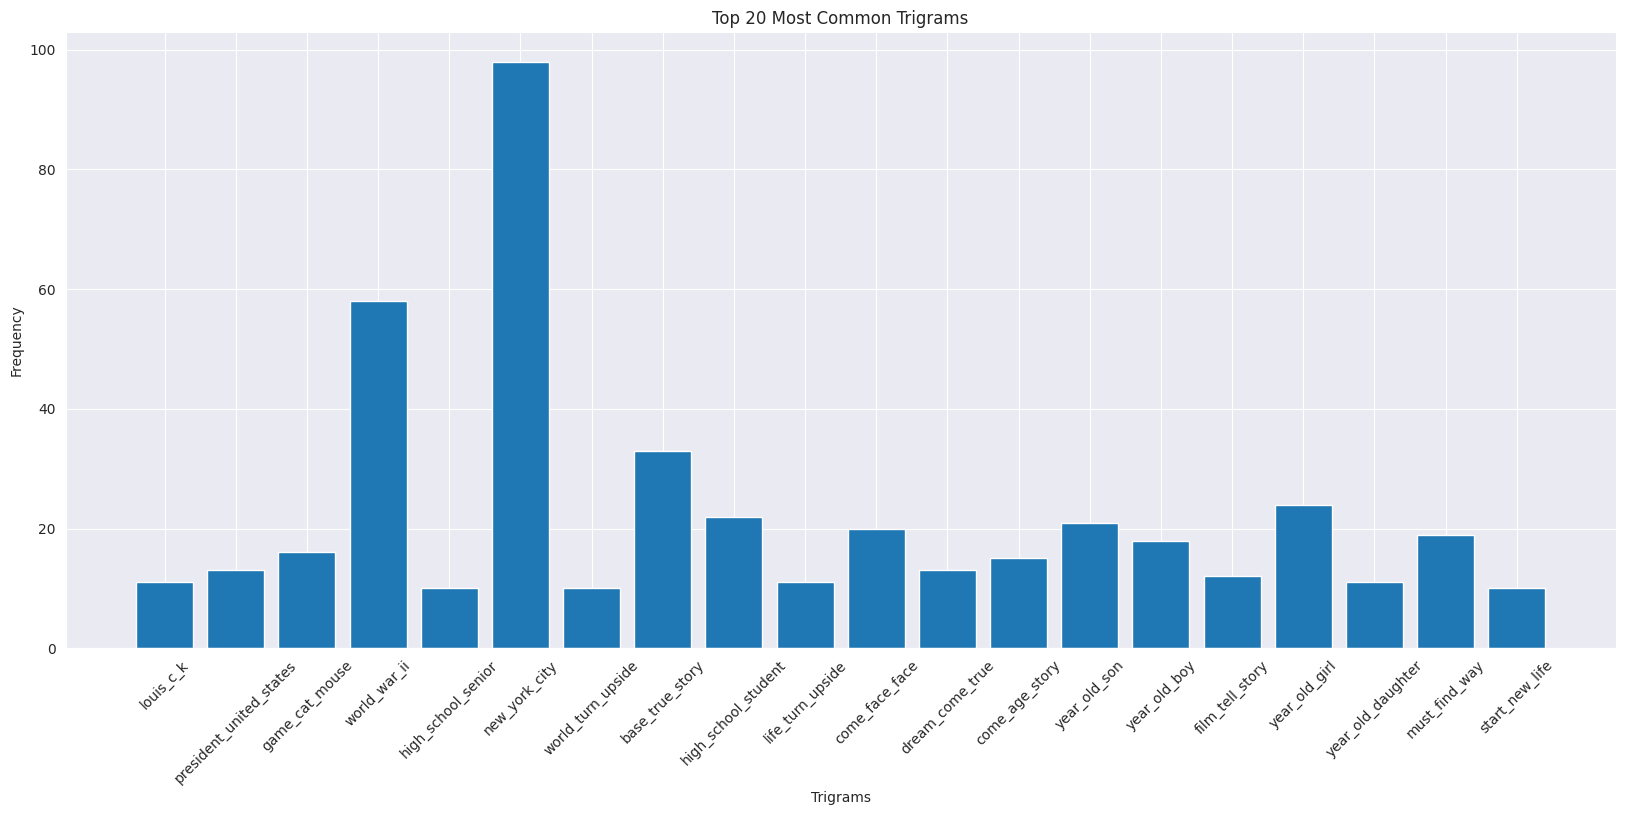

In [92]:
from collections import Counter
from nltk.collocations import TrigramAssocMeasures, TrigramCollocationFinder

# Use 'words' as a list of tokenized sentences
flat_words = [word for sentence in words for word in sentence]

# Find trigram collocations
trigram_measures = TrigramAssocMeasures()
finder = TrigramCollocationFinder.from_words(flat_words)

finder.apply_freq_filter(10)  # Only consider trigrams that appear at least 10 times

# Get the top 20 trigrams by using Pointwise Mutual Information:
top_trigrams = finder.nbest(trigram_measures.pmi, 20)

# Plot of common trigrams:
trigram_counts = Counter(finder.ngram_fd)
trigram_freqs = [trigram_counts[trigram] for trigram in top_trigrams]

plt.figure(figsize=(20, 8))
plt.bar(['_'.join(trigram) for trigram in top_trigrams], trigram_freqs)
plt.xticks(rotation=45)
plt.xlabel('Trigrams')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Trigrams')
plt.show()



The trigram new_york_city can likely be dropped given it's frequency relative to the other trigrams. Let's instead TFIDF vectorize our trigrams to look at ways to weight trigrams such as 'new_york_city' with less importance:

In [7]:
from nltk import trigrams
from sklearn.feature_extraction.text import TfidfVectorizer

def trigram_tokenizer(text):
    words = text.split()
    trigram_list = ['_'.join(trigram) for trigram in trigrams(words)]
    return trigram_list

text_data = train['overview']

vectorizer = TfidfVectorizer(tokenizer=trigram_tokenizer, ngram_range=(1, 1), min_df=3)
X = vectorizer.fit_transform(text_data)

# X is the TF-IDF feature matrix

/Users/canxiuzhang/anaconda3/envs/nlp_3_9/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


ValueError: np.nan is an invalid document, expected byte or unicode string.

In [94]:
X.shape

(7606, 536)

In [95]:
type(X)

<class 'scipy.sparse._csr.csr_matrix'>

Showing a dataframe of TFIDF trigram summations across the corpus of documents:






In [96]:
import numpy as np
import pandas as pd

# Sum the TF-IDF values for each trigram across all documents
trigram_sums = np.sum(X, axis=0)
trigram_sums = np.squeeze(np.asarray(trigram_sums))

# Create a DataFrame with trigrams and their corresponding summed TF-IDF values
trigram_scores = pd.DataFrame({"trigram": vectorizer.get_feature_names_out(), "tfidf_sum": trigram_sums})

# Sort the DataFrame based on the summed TF-IDF values in descending order
trigram_scores = trigram_scores.sort_values(by="tfidf_sum", ascending=False)

# Display the top 20 trigrams along with their summed TF-IDF scores
top_20_trigrams = trigram_scores.head(20)
print(top_20_trigrams)


                     trigram  tfidf_sum
329            new_york_city  75.525700
505             world_war_ii  52.309962
28           base_true_story  29.580844
221      high_school_student  19.412933
514            year_old_girl  19.095293
519             year_old_son  18.490906
76            come_face_face  17.438809
509             year_old_boy  16.480256
317            must_find_way  15.431585
164           game_cat_mouse  12.032969
72            come_age_story  11.135220
360  president_united_states  10.820122
104          dream_come_true  10.573899
512        year_old_daughter  10.323865
255         life_turn_upside   9.833271
220       high_school_senior   9.399393
425           start_new_life   9.172799
504        world_turn_upside   8.739557
392     secret_service_agent   7.927693
327             new_year_eve   7.718533


It seems using TFIDF trigram sum accross all documents (shown in the code block above) replicates the most frequently occuring trigrams across the corpus as seen in the 20 most common trigrams plot (also above). Instead, let's try using max TFIDF score to see if this is a more useful measure of trigram importance. 

In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer

def trigram_tokenizer(text):
    words = text.split()
    trigram_list = ['_'.join(trigram) for trigram in trigrams(words)]
    return trigram_list

text_data = train['overview']

vectorizer = TfidfVectorizer(tokenizer=trigram_tokenizer, ngram_range=(1, 1))
X = vectorizer.fit_transform(text_data)

# Calculate the maximum TF-IDF value for each trigram across all documents
trigram_max = np.max(X, axis=0).toarray().ravel()

# Create a DataFrame with trigrams and their corresponding maximum TF-IDF values
trigram_scores = pd.DataFrame({"trigram": vectorizer.get_feature_names_out(), "tfidf_max": trigram_max})

# Sort the DataFrame based on the maximum TF-IDF values in descending order
trigram_scores = trigram_scores.sort_values(by="tfidf_max", ascending=False)

# Display the top 20 trigrams along with their maximum TF-IDF scores
top_20_trigrams = trigram_scores.head(20)
print(top_20_trigrams)


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


                                 trigram  tfidf_max
174769         story_inspire_commandment   1.000000
49724            documentary_voice_actor   1.000000
49656           documentary_fraud_fakery   1.000000
94135    investigate_corporate_executive   0.707107
112679  magistrate_investigate_corporate   0.707107
140348               play_transplant_set   0.707107
164381       shakespeare_play_transplant   0.707107
111364               love_sometimes_need   0.577350
50764                    drama_set_world   0.577350
109993             look_universe_fervent   0.577350
109843             look_judicial_scandal   0.577350
147136        rabbit_terrorize_southwest   0.577350
55669                enjoy_karaoke_party   0.577350
125265           mutant_rabbit_terrorize   0.577350
205260                 world_weapon_deal   0.577350
163817                  set_world_weapon   0.577350
33655                  comedic_look_life   0.577350
86065            hilarious_look_universe   0.577350
98384       

Below, showing a dataframe of the lowest of the TFIDF maximum scores:  

In [98]:

#Sort the DataFrame based on the maximum TF-IDF values in ascending order
#This shows us the lowest maximum scores
trigram_scores = trigram_scores.sort_values(by="tfidf_max", ascending=True)

# Display the bottom 20 trigrams along with their maximum TF-IDF scores
bottom_20_trigrams = trigram_scores.head(20)
print(bottom_20_trigrams)

                           trigram  tfidf_max
134620               pack_step_way   0.098411
78213                 go_wild_mary   0.098411
36662        coolest_mischief_make   0.098411
128250               new_love_girl   0.098411
24016      california_adventure_go   0.098411
84049   heart_hollywood_disastrous   0.098411
169383               son_girl_arch   0.098411
140577           plot_every_action   0.098411
49231            diver_sister_team   0.098411
128256              new_love_newly   0.098411
60612        fabulously_funny_love   0.098411
132540            one_surfer_other   0.098411
199388                way_got_find   0.098411
133765            other_high_diver   0.098411
8083               arch_rival_girl   0.098411
73320        full_outrageous_event   0.098411
60439         eye_catch_california   0.098411
111057             love_girl_paint   0.098411
111407          love_strike_comedy   0.098411
138079           personal_ad_giant   0.098411


In [99]:
#Create the TFIDF Matrix for the test dataset as well:
test_text_data = test['overview']
X_test = vectorizer.transform(test_text_data)

In [101]:
X_test.shape

(3260, 208795)

In [102]:
X.shape

(7606, 208795)

### doc2vector

In [30]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import numpy as np

In [31]:
from gensim.models.phrases import Phrases, Phraser
from nltk import bigrams

words = [row.split() for row in train['overview']]
phrases = Phrases(words, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[words]

In [32]:
sentences

In [56]:
def get_documents(overviews):
    texts = []
    for row in overviews:
        word_array = row.split(" ")
        texts.append([x for x in word_array if x])
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(texts)]
    return texts, documents

In [57]:
train_texts, train_documents = get_documents(train['overview'])

In [75]:
model = Doc2Vec(train_documents, vector_size=100, dm=1, dm_concat=1, window=2, min_count=1, workers=4)

In [76]:
d2v_train_vectors = [model.infer_vector(text) for text in train_texts] 
d2v_train_vectors = np.array(d2v_train_vectors)

In [77]:
test_texts, test_documents = get_documents(test['overview'])
d2v_test_vectors = [model.infer_vector(text) for text in test_texts] 
d2v_test_vectors = np.array(d2v_test_vectors)

In [78]:
d2v_train_vectors.shape

(7606, 100)

In [79]:
d2v_test_vectors.shape

(3260, 100)

### doc2vec - ngrams

In [ ]:
from gensim.models.phrases import Phrases, Phraser
from nltk import bigrams

words = [row.split() for row in train['overview']]
phrases = Phrases(words, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[words]

w2v_model.build_vocab(sentences, progress_per=10000)

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

tokenizer = ToktokTokenizer()
nlp = spacy.load('en_core_web_sm')

# tokenize train reviews & encode train labels
tokenized_train = [tokenizer.tokenize(text)
                   for text in train_text]
y_train = train.drop(labels = ['id','overview', 'genres'], axis=1)
# tokenize test reviews & encode test labels
tokenized_test = [tokenizer.tokenize(text)
                   for text in test_text]
y_test = test.drop(labels = ['id','overview', 'genres'], axis=1)

# build word2vec model
w2v_num_features = 500
w2v_model = gensim.models.Word2Vec(tokenized_train, vector_size=w2v_num_features, window=150,
                                   min_count=10, sample=1e-3)  

def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

# generate averaged word vector features from word2vec model
avg_wv_train_features = averaged_word2vec_vectorizer(corpus=tokenized_train, model=w2v_model, num_features=500)
avg_wv_test_features = averaged_word2vec_vectorizer(corpus=tokenized_test, model=w2v_model, num_features=500)

# Baseline and Benchmark of Features

# Using pipeline for applying logistic regression and one vs rest classifier

OneVsRest
1. Traditional two-class and multi-class problems can both be cast into multi-label ones by restricting each instance to have only one label. On the other hand, the generality of multi-label problems inevitably makes it more difficult to learn. An intuitive approach to solving multi-label problem is to decompose it into multiple independent binary classification problems (one per category).
2. In an “one-to-rest” strategy, one could build multiple independent classifiers and, for an unseen instance, choose the class for which the confidence is maximized.
3. The main assumption here is that the labels are mutually exclusive. You do not consider any underlying correlation between the classes in this method.
4. For instance, it is more like asking simple questions, say, “is the comment toxic or not”, “is the comment threatening or not?”, etc. Also there might be an extensive case of overfitting here, since most of the comments are unlabeled, i,e., most of the comments are clean comments.

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [32]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
#printmd('**bold**')

### word2vec

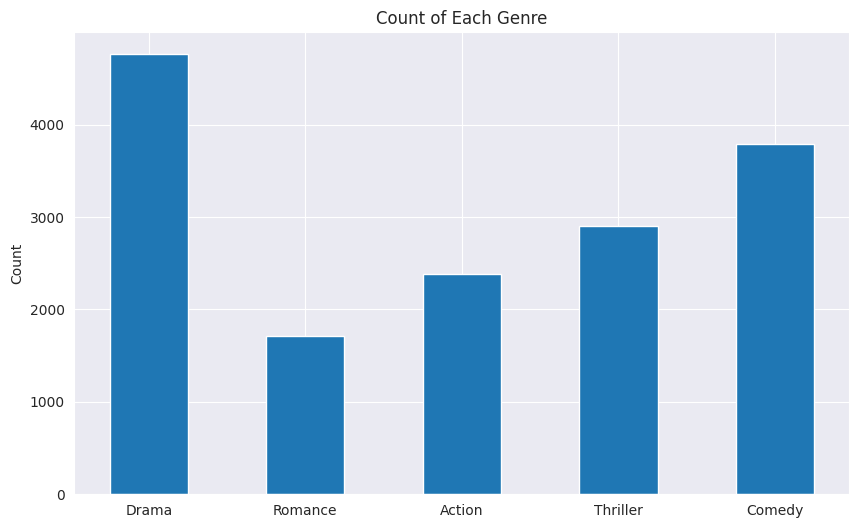

In [74]:
#Plotting the y genre columns:

genre_columns = ['Drama', 'Romance', 'Action', 'Thriller', 'Comedy']
plot_df = data[genre_columns]

# Calculate the sum of each column
column_sums = plot_df.sum(axis=0)

# Set the width of the bars
bar_width = 0.5

# Set the x-axis positions for the bars
x = np.arange(len(column_sums))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bars for each column
ax.bar(x, column_sums, width=bar_width)

# Set the x-axis tick positions and labels
ax.set_xticks(x)
ax.set_xticklabels(column_sums.index)

# Add labels and title
ax.set_ylabel('Count')
ax.set_title('Count of Each Genre')

# Show the plot
plt.show()


In [77]:
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 12.4 MB/s eta 0:00:00


In [104]:
X_train = avg_wv_train_features
y_train = train[categories]

print(X_train.shape)
print(y_train.shape)
import numpy as np
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from skmultilearn.problem_transform import LabelPowerset
from imblearn.over_sampling import SMOTE

lp = LabelPowerset()
y_train_single_label = lp.transform(y_train)
print(len(y_train_single_label))

count = {}
for i in y_train_single_label:
  count[i] = 0

for i in y_train_single_label:
  count[i] += 1

# Apply SMOTE to the transformed dataset
smote = SMOTE(random_state=42)
remove_index = []

y_new = []
for i in range(7606):
  power_label = y_train_single_label[i]
  if count[power_label] < 6:
    remove_index.append(i)
  else:
    y_new.append(y_train_single_label[i])

print(len(remove_index))
X_new = np.delete(X_train, remove_index, axis=0)

print(X_new.shape)
print(len(y_new))
X_train_resampled, y_train_single_label_resampled = smote.fit_resample(X_new, y_new)
y_train_resampled = lp.inverse_transform(y_train_single_label_resampled)
y_df = pd.DataFrame(y_train_resampled.toarray(), columns=categories)

(7606, 500)
(7606, 5)
7606
9
(7597, 500)
7597


In [108]:
print(y_train_resampled.shape)
print(X_train_resampled.shape)

(32451, 5)
(32451, 500)


In [109]:
type(y_train_resampled)

<class 'numpy.ndarray'>

In [110]:
# X_train_resampled = np.array(X_train_resampled)
# y_train_resampled = y_train_resampled.toarray()
np.savetxt('../X_train_resampled.csv', X_train_resampled, delimiter=',')
np.savetxt('../y_train_resampled.csv', y_train_resampled, delimiter=',')

**Processing Action overview...**

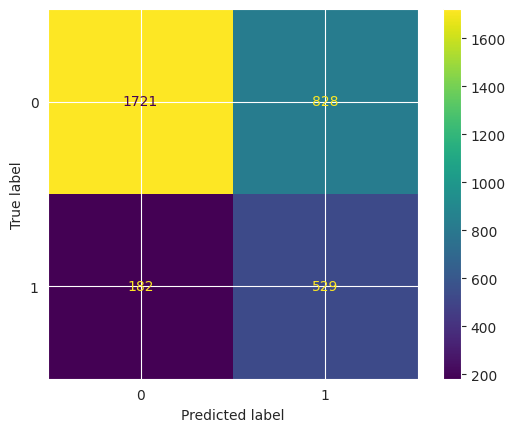

Test accuracy is 0.6901840490797546
Test f1 is 0.511605415860735
Test precision score is 0.3898305084745763
Test recall score is 0.7440225035161744
Test roc auc score is 0.7095946177839797




**Processing Comedy overview...**

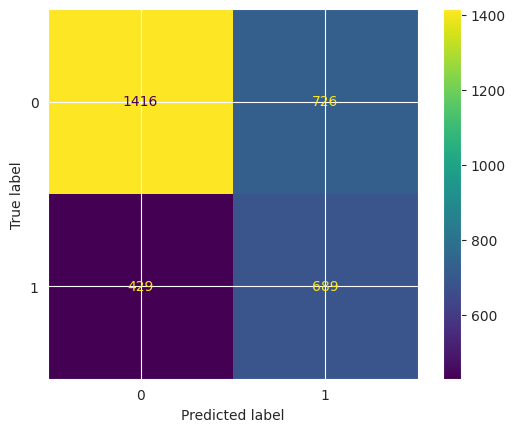

Test accuracy is 0.6457055214723927
Test f1 is 0.5440189498618239
Test precision score is 0.48692579505300354
Test recall score is 0.6162790697674418
Test roc auc score is 0.638671747768875




**Processing Drama overview...**

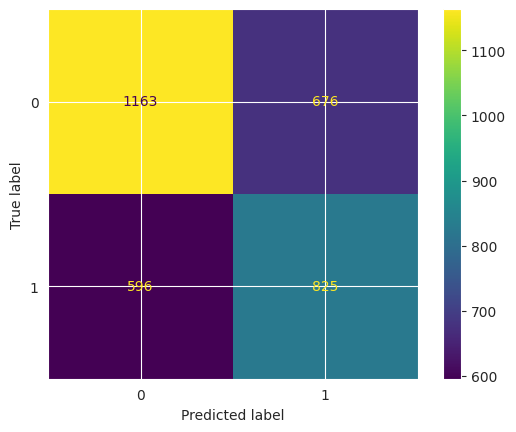

Test accuracy is 0.6098159509202454
Test f1 is 0.5646817248459959
Test precision score is 0.5496335776149234
Test recall score is 0.5805770584095707
Test roc auc score is 0.6064929881498643




**Processing Thriller overview...**

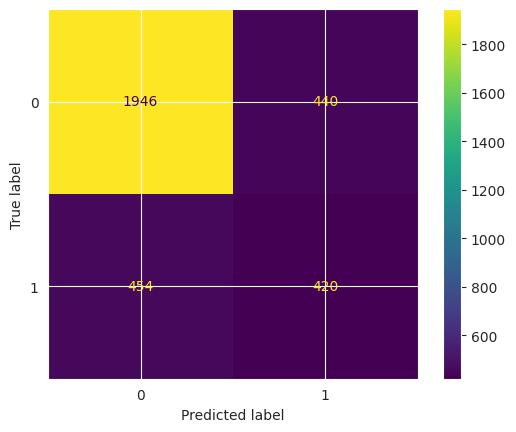

Test accuracy is 0.7257668711656442
Test f1 is 0.4844290657439446
Test precision score is 0.4883720930232558
Test recall score is 0.4805491990846682
Test roc auc score is 0.6480700731383106




**Processing Romance overview...**

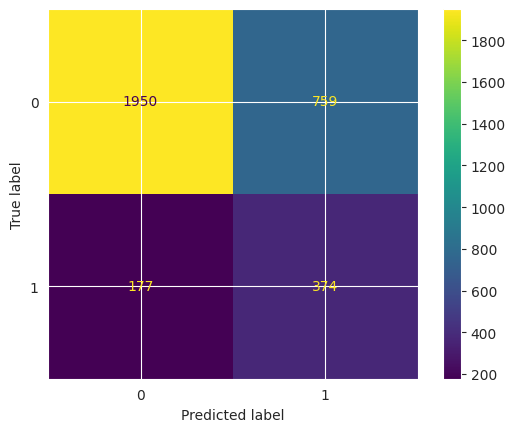

Test accuracy is 0.7128834355828221
Test f1 is 0.44418052256532065
Test precision score is 0.3300970873786408
Test recall score is 0.6787658802177858
Test roc auc score is 0.6992943465319272


CPU times: user 1.8 s, sys: 1.11 s, total: 2.91 s
Wall time: 30.8 s


In [82]:
%%time

# from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])

# dummy_pipeline = Pipeline([
#                 ('clf', OneVsRestClassifier(DummyClassifier(), n_jobs=-1)),
#             ])

for category in categories:
    printmd('**Processing {} overview...**'.format(category))
    
    # Training logistic regression model on train data
    model = LogReg_pipeline.fit(X_train_resampled, y_df[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(avg_wv_test_features)

    cm = confusion_matrix(test[category], prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print('Test f1 is {}'.format(f1_score(test[category], prediction)))
    print('Test precision score is {}'.format(precision_score(test[category], prediction)))
    print('Test recall score is {}'.format(recall_score(test[category], prediction)))
    print('Test roc auc score is {}'.format(roc_auc_score(test[category], prediction)))
    print("\n")

### GloVe

In [83]:
X_train = train_glove_features
y_train = train[categories]

print(X_train.shape)
print(y_train.shape)
import numpy as np
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from skmultilearn.problem_transform import LabelPowerset
from imblearn.over_sampling import SMOTE

lp = LabelPowerset()
y_train_single_label = lp.transform(y_train)
print(len(y_train_single_label))

count = {}
for i in y_train_single_label:
  count[i] = 0

for i in y_train_single_label:
  count[i] += 1

# Apply SMOTE to the transformed dataset
smote = SMOTE(random_state=42)
remove_index = []

y_new = []
for i in range(7606):
  power_label = y_train_single_label[i]
  if count[power_label] < 6:
    remove_index.append(i)
  else:
    y_new.append(y_train_single_label[i])

print(len(remove_index))
X_new = np.delete(X_train, remove_index, axis=0)

print(X_new.shape)
print(len(y_new))
X_train_resampled, y_train_single_label_resampled = smote.fit_resample(X_new, y_new)
y_train_resampled = lp.inverse_transform(y_train_single_label_resampled)
y_df = pd.DataFrame(y_train_resampled.toarray(), columns=categories)

(7606, 96)
(7606, 5)
7606
9
(7597, 96)
7597


**Processing Action overview...**

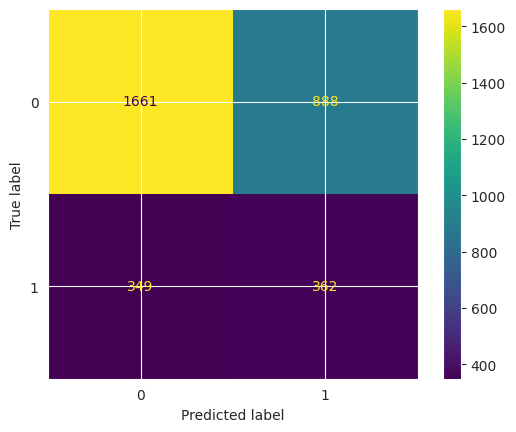

Test accuracy is 0.6205521472392638
Test f1 is 0.3691993880673127
Test precision score is 0.2896
Test recall score is 0.509142053445851
Test roc auc score is 0.5803850714463464




**Processing Comedy overview...**

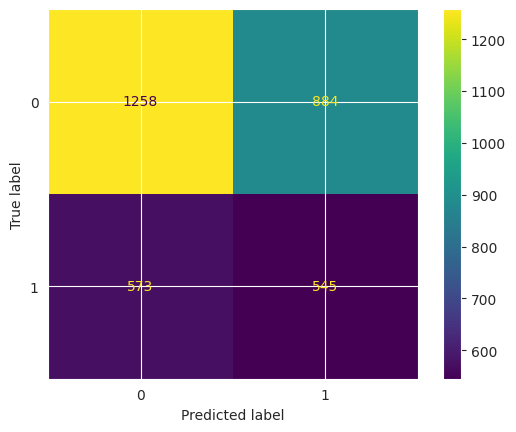

Test accuracy is 0.5530674846625767
Test f1 is 0.4279544562230075
Test precision score is 0.3813855843247026
Test recall score is 0.4874776386404293
Test roc auc score is 0.5373896129710083




**Processing Drama overview...**

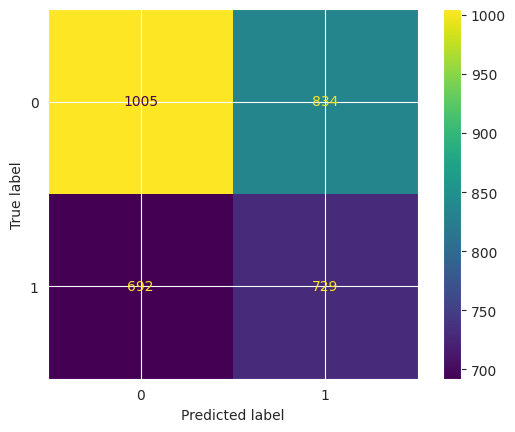

Test accuracy is 0.5319018404907976
Test f1 is 0.4886058981233244
Test precision score is 0.46641074856046066
Test recall score is 0.5130190007037297
Test roc auc score is 0.5297558298787817




**Processing Thriller overview...**

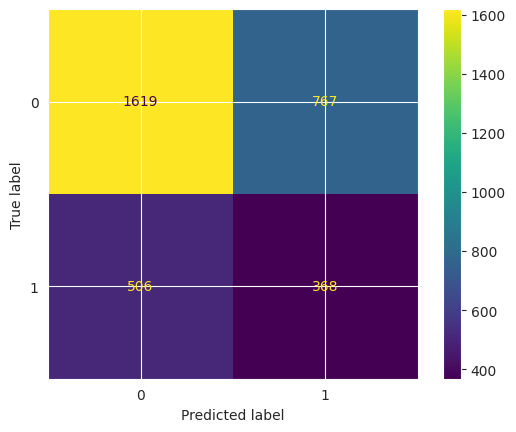

Test accuracy is 0.6095092024539878
Test f1 is 0.366351418616227
Test precision score is 0.32422907488986785
Test recall score is 0.42105263157894735
Test roc auc score is 0.5497970618079145




**Processing Romance overview...**

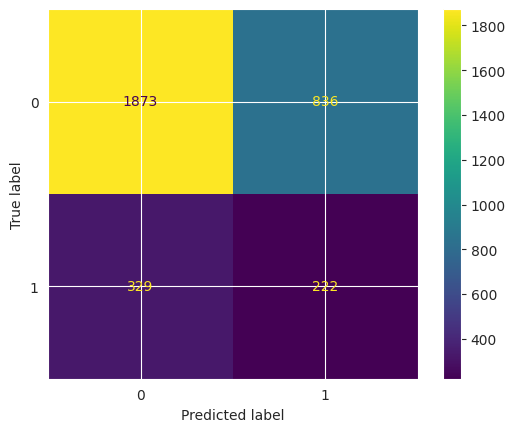

Test accuracy is 0.6426380368098159
Test f1 is 0.2759477936606588
Test precision score is 0.20982986767485823
Test recall score is 0.4029038112522686
Test roc auc score is 0.5471514257442591


CPU times: user 1.59 s, sys: 757 ms, total: 2.35 s
Wall time: 20.1 s


In [84]:
%%time
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])

for category in categories:
    printmd('**Processing {} overview...**'.format(category))
    
    # Training logistic regression model on train data
    model = LogReg_pipeline.fit(X_train_resampled, y_df[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(test_glove_features)
    cm = confusion_matrix(test[category], prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print('Test f1 is {}'.format(f1_score(test[category], prediction)))
    print('Test precision score is {}'.format(precision_score(test[category], prediction)))
    print('Test recall score is {}'.format(recall_score(test[category], prediction)))
    print('Test roc auc score is {}'.format(roc_auc_score(test[category], prediction)))
    print("\n")

### TD-IDF

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(train_text)
vectorizer.fit(test_text)

x_train = vectorizer.transform(train_text)
y_train = train.drop(labels = ['id','overview', 'genres'], axis=1)
x_test = vectorizer.transform(test_text)
y_test = test.drop(labels = ['id','overview', 'genres'], axis=1)

In [25]:
x_train.shape

(7606, 185395)

In [104]:
# type(X_test)
type(X)
# X.shape

<class 'scipy.sparse._csr.csr_matrix'>

In [26]:
X_train = x_train
y_train = train[categories]

print(X_train.shape)
print(y_train.shape)
import numpy as np
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from skmultilearn.problem_transform import LabelPowerset
from imblearn.over_sampling import SMOTE

lp = LabelPowerset()
y_train_single_label = lp.transform(y_train)
print(len(y_train_single_label))

count = {}
for i in y_train_single_label:
  count[i] = 0

for i in y_train_single_label:
  count[i] += 1

# Apply SMOTE to the transformed dataset
smote = SMOTE(random_state=42)
remove_index = []

y_new = []
for i in range(7606):
  power_label = y_train_single_label[i]
  if count[power_label] < 6:
    remove_index.append(i)
  else:
    y_new.append(y_train_single_label[i])

print(len(remove_index))



(7606, 185395)
(7606, 5)
7606
9


In [27]:
def delete_row_csr(mat, i):
    n = mat.indptr[i+1] - mat.indptr[i]
    if n > 0:
        mat.data[mat.indptr[i]:-n] = mat.data[mat.indptr[i+1]:]
        mat.data = mat.data[:-n]
        mat.indices[mat.indptr[i]:-n] = mat.indices[mat.indptr[i+1]:]
        mat.indices = mat.indices[:-n]
    mat.indptr[i:-1] = mat.indptr[i+1:]
    mat.indptr[i:] -= n
    mat.indptr = mat.indptr[:-1]
    mat._shape = (mat._shape[0]-1, mat._shape[1])

for i in remove_index:
    delete_row_csr(X_train, i)

print(X_train.shape)


(7597, 185395)


In [28]:
print(len(y_new))
X_train_resampled, y_train_single_label_resampled = smote.fit_resample(X_train, y_new)
y_train_resampled = lp.inverse_transform(y_train_single_label_resampled)
y_df = pd.DataFrame(y_train_resampled.toarray(), columns=categories)

7597


**Processing Action overview...**

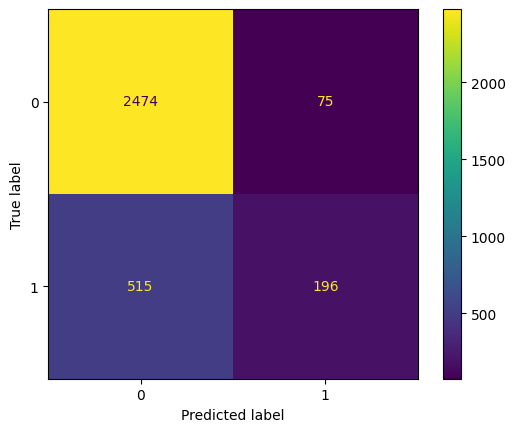

Test accuracy is 0.8190184049079755
Test f1 is 0.39918533604887985
Test precision score is 0.7232472324723247
Test recall score is 0.27566807313642755
Test roc auc score is 0.6231223849401243




**Processing Comedy overview...**

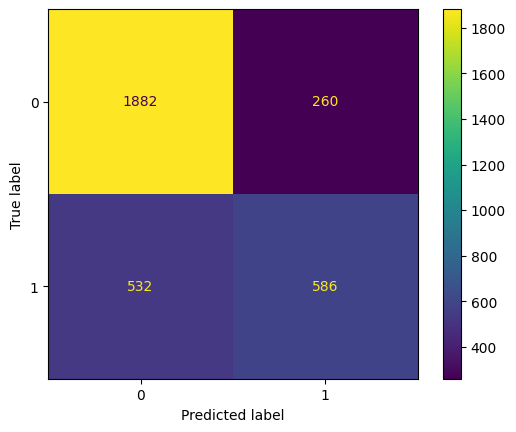

Test accuracy is 0.7570552147239263
Test f1 is 0.5967413441955193
Test precision score is 0.6926713947990544
Test recall score is 0.5241502683363148
Test roc auc score is 0.7013841911242732




**Processing Drama overview...**

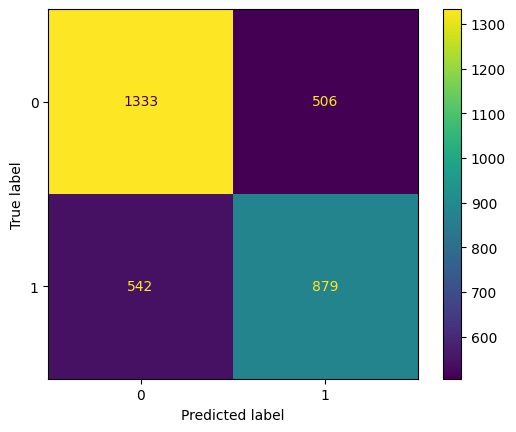

Test accuracy is 0.6785276073619632
Test f1 is 0.6265146115466856
Test precision score is 0.6346570397111914
Test recall score is 0.6185784658691063
Test roc auc score is 0.671714464038414




**Processing Thriller overview...**

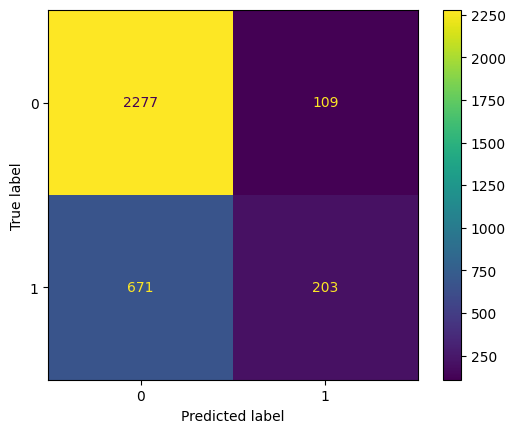

Test accuracy is 0.7607361963190185
Test f1 is 0.342327150084317
Test precision score is 0.6506410256410257
Test recall score is 0.2322654462242563
Test roc auc score is 0.5932911472529496




**Processing Romance overview...**

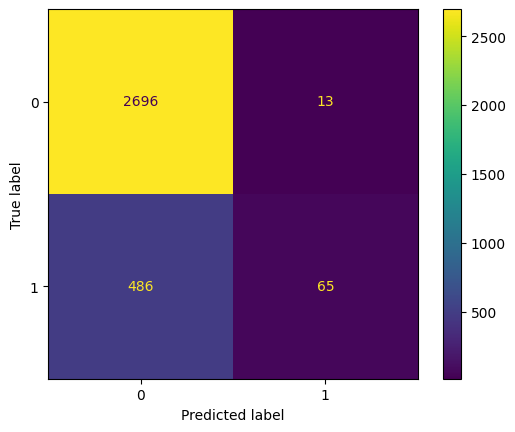

Test accuracy is 0.8469325153374233
Test f1 is 0.20667726550079493
Test precision score is 0.8333333333333334
Test recall score is 0.11796733212341198
Test roc auc score is 0.5565842566855524


CPU times: user 1.54 s, sys: 391 ms, total: 1.93 s
Wall time: 21.9 s


In [33]:
%%time

# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])

for category in categories:
    printmd('**Processing {} overview...**'.format(category))
    
    # Training logistic regression model on train data
    model = LogReg_pipeline.fit(X_train_resampled, y_df[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(x_test)
    cm = confusion_matrix(test[category], prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print('Test f1 is {}'.format(f1_score(test[category], prediction)))
    print('Test precision score is {}'.format(precision_score(test[category], prediction)))
    print('Test recall score is {}'.format(recall_score(test[category], prediction)))
    print('Test roc auc score is {}'.format(roc_auc_score(test[category], prediction)))
    print("\n")

### doc2vec

In [80]:
X_train = d2v_train_vectors
y_train = train[categories]

print(X_train.shape)
print(y_train.shape)
import numpy as np
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from skmultilearn.problem_transform import LabelPowerset
from imblearn.over_sampling import SMOTE

lp = LabelPowerset()
y_train_single_label = lp.transform(y_train)
print(len(y_train_single_label))

count = {}
for i in y_train_single_label:
  count[i] = 0

for i in y_train_single_label:
  count[i] += 1

# Apply SMOTE to the transformed dataset
smote = SMOTE(random_state=42)
remove_index = []

y_new = []
for i in range(7606):
  power_label = y_train_single_label[i]
  if count[power_label] < 6:
    remove_index.append(i)
  else:
    y_new.append(y_train_single_label[i])

print(len(remove_index))
X_new = np.delete(X_train, remove_index, axis=0)

print(X_new.shape)
print(len(y_new))
X_train_resampled, y_train_single_label_resampled = smote.fit_resample(X_new, y_new)
y_train_resampled = lp.inverse_transform(y_train_single_label_resampled)
y_df = pd.DataFrame(y_train_resampled.toarray(), columns=categories)

(7606, 100)
(7606, 5)
7606
9
(7597, 100)
7597


**Processing Action overview...**

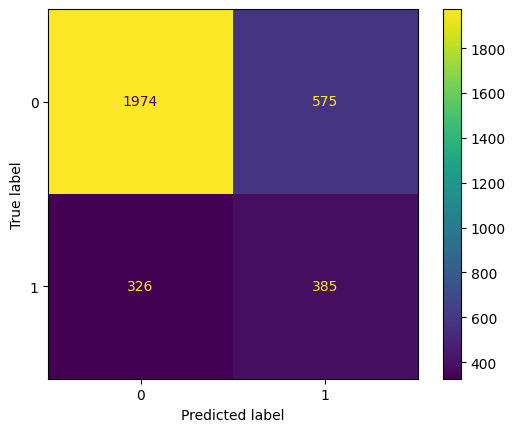

Test accuracy is 0.7236196319018405
Test f1 is 0.4608019150209456
Test precision score is 0.4010416666666667
Test recall score is 0.5414908579465542
Test roc auc score is 0.6579560998245914




**Processing Comedy overview...**

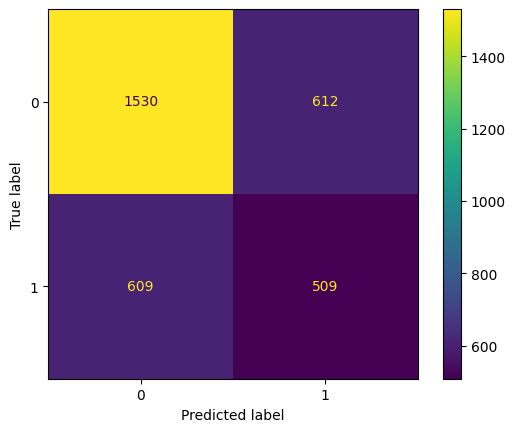

Test accuracy is 0.6254601226993866
Test f1 is 0.4546672621706119
Test precision score is 0.45405887600356826
Test recall score is 0.4552772808586762
Test roc auc score is 0.5847814975721953




**Processing Drama overview...**

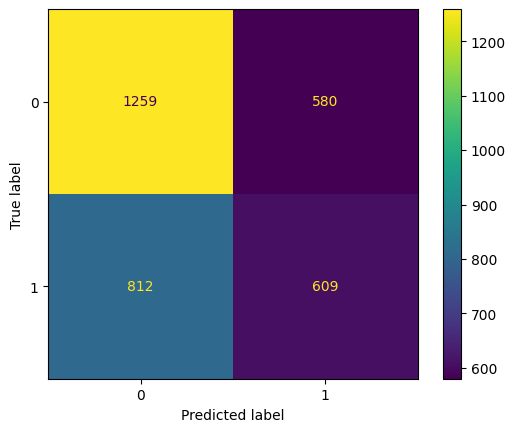

Test accuracy is 0.5730061349693252
Test f1 is 0.4666666666666667
Test precision score is 0.5121951219512195
Test recall score is 0.42857142857142855
Test roc auc score is 0.5565913151557523




**Processing Thriller overview...**

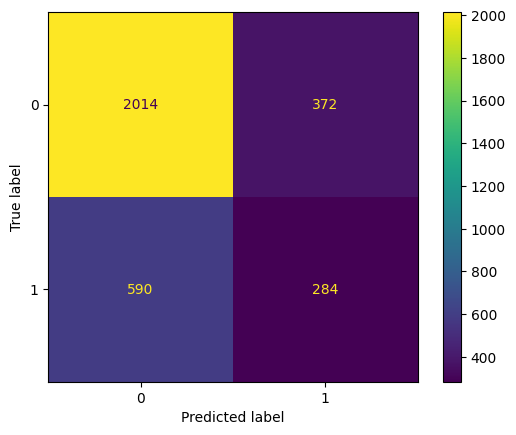

Test accuracy is 0.7049079754601227
Test f1 is 0.3712418300653595
Test precision score is 0.4329268292682927
Test recall score is 0.32494279176201374
Test roc auc score is 0.5845166599212416




**Processing Romance overview...**

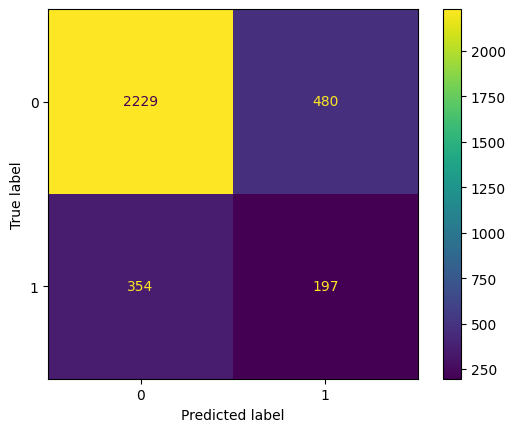

Test accuracy is 0.7441717791411043
Test f1 is 0.3208469055374593
Test precision score is 0.29098966026587886
Test recall score is 0.35753176043557167
Test roc auc score is 0.5901723032521158


CPU times: user 1.67 s, sys: 267 ms, total: 1.94 s
Wall time: 12.2 s


In [81]:
%%time

# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])

for category in categories:
    printmd('**Processing {} overview...**'.format(category))
    
    # Training logistic regression model on train data
    model = LogReg_pipeline.fit(X_train_resampled, y_df[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(d2v_test_vectors)
    cm = confusion_matrix(test[category], prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print('Test f1 is {}'.format(f1_score(test[category], prediction)))
    print('Test precision score is {}'.format(precision_score(test[category], prediction)))
    print('Test recall score is {}'.format(recall_score(test[category], prediction)))
    print('Test roc auc score is {}'.format(roc_auc_score(test[category], prediction)))
    print("\n")

# 4. Classifiers

In [5]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd

categories = ['Action', 'Comedy', 'Drama', 'Thriller', 'Romance']
train = pd.read_csv('../train.csv', keep_default_na=False, na_values=[''])
test = pd.read_csv('../test.csv', keep_default_na=False, na_values=[''])
avg_wv_train_features = np.loadtxt('../avg_wv_train_features.csv', delimiter=',')
avg_wv_test_features = np.loadtxt('../avg_wv_test_features.csv', delimiter=',')
x_train_resampled = np.loadtxt('../X_train_resampled.csv', delimiter=',')
y_train_resampled = np.loadtxt('../y_train_resampled.csv', delimiter=',')

x_train = avg_wv_train_features
x_test = avg_wv_test_features
y_train = train[categories]
y_test = test[categories]

## Classifier Chains - before resample

In [112]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression
# initialize classifier chains multi-label classifier
classifier = ClassifierChain(LogisticRegression())
# Training logistic regression model on train data
classifier.fit(x_train, y_train)
# predict
predictions = classifier.predict(x_test)
# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))
print("\n")

# Calculate and print the classification report
report = classification_report(y_test, predictions, zero_division=0)
print("Classification Report:\n", report)


Accuracy =  0.18957055214723925


Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.17      0.26       711
           1       0.64      0.23      0.34      1118
           2       0.52      0.63      0.57      1421
           3       0.51      0.22      0.30       874
           4       0.58      0.07      0.13       551

   micro avg       0.54      0.32      0.40      4675
   macro avg       0.56      0.26      0.32      4675
weighted avg       0.56      0.32      0.37      4675
 samples avg       0.40      0.29      0.31      4675



## Classifier Chains - after resample

In [113]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression
# initialize classifier chains multi-label classifier
classifier = ClassifierChain(LogisticRegression())
# Training logistic regression model on train data
classifier.fit(x_train_resampled, y_train_resampled)
# predict
predictions = classifier.predict(x_test)
# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))
print("\n")

# Calculate and print the classification report
report = classification_report(y_test, predictions, zero_division=0)
print("Classification Report:\n", report)

Accuracy =  0.13098159509202453


Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.74      0.51       711
           1       0.49      0.59      0.54      1118
           2       0.54      0.62      0.57      1421
           3       0.49      0.51      0.50       874
           4       0.34      0.66      0.45       551

   micro avg       0.45      0.61      0.52      4675
   macro avg       0.45      0.62      0.51      4675
weighted avg       0.47      0.61      0.53      4675
 samples avg       0.44      0.54      0.45      4675



## Binary Relevance - before resample

In [114]:
# using binary relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(GaussianNB())
# train
classifier.fit(x_train, y_train)
# predict
predictions = classifier.predict(x_test)
# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))

# Calculate and print the classification report
report = classification_report(y_test, predictions, zero_division=0)
print("Classification Report:\n", report)

Accuracy =  0.09018404907975461
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.73      0.45       711
           1       0.43      0.60      0.50      1118
           2       0.50      0.53      0.52      1421
           3       0.34      0.74      0.46       874
           4       0.26      0.67      0.38       551

   micro avg       0.37      0.63      0.47      4675
   macro avg       0.37      0.65      0.46      4675
weighted avg       0.40      0.63      0.48      4675
 samples avg       0.34      0.54      0.39      4675



## Binary Relevance - after resample

In [115]:
# using binary relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(GaussianNB())
# train
classifier.fit(x_train_resampled, y_train_resampled)
# predict
predictions = classifier.predict(x_test)
# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))

# Calculate and print the classification report
report = classification_report(y_test, predictions, zero_division=0)
print("Classification Report:\n", report)

Accuracy =  0.07668711656441718
Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.74      0.45       711
           1       0.39      0.67      0.50      1118
           2       0.51      0.57      0.54      1421
           3       0.33      0.66      0.44       874
           4       0.25      0.73      0.37       551

   micro avg       0.36      0.66      0.46      4675
   macro avg       0.36      0.67      0.46      4675
weighted avg       0.39      0.66      0.48      4675
 samples avg       0.37      0.57      0.41      4675



## Label Powerset - before resample

In [120]:
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset
# initialize label powerset multi-label classifier
classifier = LabelPowerset(LogisticRegression())
# train
classifier.fit(x_train, y_train)
# predict
predictions = classifier.predict(x_test)
# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))
print("\n")

# Calculate and print the classification report
report = classification_report(y_test, predictions, zero_division=0)
print("Classification Report:\n", report)

Accuracy =  0.20889570552147238


Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.19      0.28       711
           1       0.46      0.53      0.50      1118
           2       0.61      0.37      0.46      1421
           3       0.52      0.16      0.24       874
           4       0.50      0.03      0.05       551

   micro avg       0.53      0.30      0.38      4675
   macro avg       0.53      0.25      0.31      4675
weighted avg       0.54      0.30      0.35      4675
 samples avg       0.38      0.28      0.30      4675



## Label Powerset - after resample

In [117]:
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset
# initialize label powerset multi-label classifier
classifier = LabelPowerset(LogisticRegression())
# train
classifier.fit(x_train_resampled, y_train_resampled)
# predict
predictions = classifier.predict(x_test)
# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))
print("\n")

# Calculate and print the classification report
report = classification_report(y_test, predictions, zero_division=0)
print("Classification Report:\n", report)

Accuracy =  0.09018404907975461


Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.77      0.46       711
           1       0.42      0.57      0.49      1118
           2       0.50      0.41      0.45      1421
           3       0.36      0.44      0.39       874
           4       0.24      0.79      0.37       551

   micro avg       0.36      0.55      0.44      4675
   macro avg       0.37      0.60      0.43      4675
weighted avg       0.40      0.55      0.44      4675
 samples avg       0.34      0.47      0.37      4675



## Adapted Algorithm - before resample

In [7]:
y_train = y_train.values

In [8]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(type(x_train))
print(type(y_train))
print(type(x_test))

(7606, 500)
(7606, 5)
(3260, 500)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==0.24.1

In [9]:
from skmultilearn.adapt import MLkNN
from scipy.sparse import csr_matrix, lil_matrix

n_neighbors = 10
classifier_new = MLkNN(k=n_neighbors, s=n_neighbors//2) # n_neighbors is the number of output classes
# Note that this classifier can throw up errors when handling sparse matrices.
x_train = csr_matrix(lil_matrix(x_train))
y_train = csr_matrix(lil_matrix(y_train))
x_test = csr_matrix(lil_matrix(x_test))
# train
classifier_new.fit(x_train, y_train)
# predict
predictions_new = classifier_new.predict(x_test)
# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions_new))

/Users/canxiuzhang/anaconda3/envs/nlp_3_9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy =  0.1705521472392638


In [11]:
# Calculate and print the classification report
report = classification_report(y_test, predictions_new, zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.36      0.42       711
           1       0.51      0.30      0.38      1118
           2       0.52      0.52      0.52      1421
           3       0.47      0.30      0.37       874
           4       0.45      0.17      0.24       551

   micro avg       0.50      0.36      0.42      4675
   macro avg       0.49      0.33      0.39      4675
weighted avg       0.50      0.36      0.41      4675
 samples avg       0.37      0.32      0.32      4675



## Adapted Algorithm - after resample

In [12]:
from skmultilearn.adapt import MLkNN
from scipy.sparse import csr_matrix, lil_matrix

n_neighbors = 10
classifier_new = MLkNN(k=n_neighbors, s=n_neighbors//2) # n_neighbors is the number of output classes
# Note that this classifier can throw up errors when handling sparse matrices.
x_train = csr_matrix(lil_matrix(x_train_resampled))
y_train = csr_matrix(lil_matrix(y_train_resampled))
x_test = csr_matrix(lil_matrix(x_test))
# train
classifier_new.fit(x_train, y_train)
# predict
predictions_new = classifier_new.predict(x_test)
# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions_new))

# Calculate and print the classification report
report = classification_report(y_test, predictions_new, zero_division=0)
print("Classification Report:\n", report)

/Users/canxiuzhang/anaconda3/envs/nlp_3_9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


ValueError: Inexact indices into sparse matrices are not allowed

1. use selected features
2. hyper parameter tuning
3. ** try w2v from google
4. ensemble - one line for now